## MSELoss for rjr

In [4]:
import pandas as pd
import torch

In [5]:
gen_df, reco_df = pd.read_csv("../../wlnu/data/gen.csv"), pd.read_csv("../../wlnu/data/reco.csv")

In [49]:
def get_torch_tensor(series):
    return torch.from_numpy(series.to_numpy().reshape((-1, 1)))

gen = get_torch_tensor(gen_df["Nu_pz"])
reco = get_torch_tensor(reco_df["Nu_pz"])
print(gen.shape)
print(reco.shape)

torch.Size([100000, 1])
torch.Size([100000, 1])


In [40]:
loss_fn = torch.nn.MSELoss()
loss_fn(gen, reco)

tensor(2684.6451, dtype=torch.float64)

## MSELoss for model and rjr

In [43]:
import sys
import os
sys.path.append(os.path.abspath("../../wlnu"))

In [44]:
print(sys.path)

['/Users/vlad/Documents/EPEprojects/MissingMassRegression/notebooks/wlnu', '/Users/vlad/anaconda3/envs/missing-mass-env/lib/python38.zip', '/Users/vlad/anaconda3/envs/missing-mass-env/lib/python3.8', '/Users/vlad/anaconda3/envs/missing-mass-env/lib/python3.8/lib-dynload', '', '/Users/vlad/anaconda3/envs/missing-mass-env/lib/python3.8/site-packages', '/Users/vlad/anaconda3/envs/missing-mass-env/lib/python3.8/site-packages/IPython/extensions', '/Users/vlad/.ipython', '..', '../..', '../..', '../../', '/Users/vlad/Documents/EPEprojects/MissingMassRegression', '/Users/vlad/Documents/EPEprojects/MissingMassRegression/notebooks', '/Users/vlad/Documents/EPEprojects/MissingMassRegression/notebooks', '/Users/vlad/Documents/EPEprojects/MissingMassRegression', '/Users/vlad/Documents/EPEprojects/MissingMassRegression/wlnu']


In [45]:
import pytorch_lightning as pl
from model import WLNuModel

In [46]:
model = WLNuModel.load_from_checkpoint("../../wlnu/best/hz1p5ftv/checkpoints/epoch=22-step=2023.ckpt", n_features=5)

In [47]:
X = gen_df.drop(labels=["W_px", "W_py", "W_pz", "W_m", "L_m", "Nu_m", "Nu_pz"], axis=1)
display(X)
X = torch.from_numpy(X.values).float()
X

,L_px,L_py,L_pz,Nu_px,Nu_py
0,6.665028,41.530350,-2.259977,-53.425700,-0.518545
1,-16.143060,-23.715470,55.236140,9.699999,32.998380
2,40.762100,64.186340,8.116494,17.691340,-15.833320
3,-33.708560,-20.902200,19.969680,-1.217451,55.449920
4,6.582341,-29.098750,-5.918424,54.048060,36.647770
...,...,...,...,...,...
99995,-9.844193,25.298100,18.010840,-36.627150,-62.418640
99996,-16.599050,39.591210,27.982240,14.880600,-34.092520
99997,52.768890,5.488154,10.270450,-29.567100,5.900311
99998,-6.706760,33.673190,-46.750920,8.259793,-40.550080


tensor([[  6.6650,  41.5303,  -2.2600, -53.4257,  -0.5185],
        [-16.1431, -23.7155,  55.2361,   9.7000,  32.9984],
        [ 40.7621,  64.1863,   8.1165,  17.6913, -15.8333],
        ...,
        [ 52.7689,   5.4882,  10.2704, -29.5671,   5.9003],
        [ -6.7068,  33.6732, -46.7509,   8.2598, -40.5501],
        [-48.3733,  22.5222,  -6.6519, -21.1367, -31.9641]])

In [48]:
Y_prime = model(X).detach().numpy().reshape((-1))

display(Y_prime)
gen_df["Nu_pz"]

array([ -7.006938 ,   4.7705956,   2.69607  , ...,   7.4013886,
       -14.9705515,   2.9665475], dtype=float32)

0       -41.595910
1        -1.899506
2       -26.579520
3        24.292260
4       -57.285080
           ...    
99995    43.934380
99996    17.785990
99997    21.582950
99998   -19.256980
99999    41.075580
Name: Nu_pz, Length: 100000, dtype: float64

In [49]:
loss_fn = torch.nn.MSELoss()
loss_fn(gen, get_torch_tensor(model_df["Nu_pz"]))

NameError: name 'gen' is not defined

In [50]:
model_df = pd.DataFrame()

model_df["L_px"] = gen_df["L_px"]
model_df["L_py"] = gen_df["L_py"]
model_df["L_pz"] = gen_df["L_pz"]
model_df["L_m"] = gen_df["L_m"]

model_df["Nu_px"] = gen_df["Nu_px"]
model_df["Nu_py"] = gen_df["Nu_py"]
model_df["Nu_pz"] = Y_prime

model_df["Nu_m"] = gen_df["Nu_m"]

model_df["W_px"] = model_df["L_px"] + model_df["Nu_px"]
model_df["W_py"] = model_df["L_py"] + model_df["Nu_py"]
model_df["W_pz"] = model_df["L_pz"] + model_df["Nu_pz"]

L_E = (model_df["L_px"] ** 2 + model_df["L_py"] ** 2 + model_df["L_pz"] ** 2) ** 0.5
Nu_E = (model_df["Nu_px"] ** 2 + model_df["Nu_py"] ** 2 + model_df["Nu_pz"] ** 2) ** 0.5
W_E2 = (L_E + Nu_E) ** 2
W_p2 = (model_df["W_px"] ** 2 + model_df["W_py"] ** 2 + model_df["W_pz"] ** 2)

model_df["W_m"] = (W_E2 - W_p2) ** 0.5

cols = model_df.columns.tolist()
model_df = model_df[cols[-4:] + cols[:-4]]

model_df

,W_px,W_py,W_pz,W_m,L_px,L_py,L_pz,L_m,Nu_px,Nu_py,Nu_pz,Nu_m
0,-46.760672,41.011805,-9.266915,72.547667,6.665028,41.530350,-2.259977,-4.768372e-07,-53.425700,-0.518545,-7.006938,0.000000e+00
1,-6.443061,9.282910,60.006736,75.324961,-16.143060,-23.715470,55.236140,-6.743496e-07,9.699999,32.998380,4.770596,-4.768372e-07
2,58.453440,48.353020,10.812564,64.813899,40.762100,64.186340,8.116494,1.348699e-06,17.691340,-15.833320,2.696070,6.743496e-07
3,-34.926011,34.547720,40.363525,81.668759,-33.708560,-20.902200,19.969680,-9.536743e-07,-1.217451,55.449920,20.393845,-6.743496e-07
4,60.630401,7.549020,-13.334589,73.016103,6.582341,-29.098750,-5.918424,7.539457e-07,54.048060,36.647770,-7.416165,-9.536743e-07
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-46.471343,-37.120540,44.689070,80.632263,-9.844193,25.298100,18.010840,4.768372e-07,-36.627150,-62.418640,26.678230,0.000000e+00
99996,-1.718450,5.498690,48.724572,79.986188,-16.599050,39.591210,27.982240,-6.743496e-07,14.880600,-34.092520,20.742332,-4.768372e-07
99997,23.201790,11.388465,17.671839,79.113386,52.768890,5.488154,10.270450,-9.536743e-07,-29.567100,5.900311,7.401389,4.768372e-07
99998,1.553033,-6.876890,-61.721471,80.914563,-6.706760,33.673190,-46.750920,-1.168008e-06,8.259793,-40.550080,-14.970551,0.000000e+00


In [51]:
gen_df

,W_px,W_py,W_pz,W_m,L_px,L_py,L_pz,L_m,Nu_px,Nu_py,Nu_pz,Nu_m
0,-46.760670,41.011800,-43.85589,79.19306,6.665028,41.530350,-2.259977,-4.768372e-07,-53.425700,-0.518545,-41.595910,0.000000e+00
1,-6.443056,9.282914,53.33664,79.85141,-16.143060,-23.715470,55.236140,-6.743496e-07,9.699999,32.998380,-1.899506,-4.768372e-07
2,58.453440,48.353020,-18.46302,80.45028,40.762100,64.186340,8.116494,1.348699e-06,17.691340,-15.833320,-26.579520,6.743496e-07
3,-34.926010,34.547720,44.26195,81.50707,-33.708560,-20.902200,19.969680,-9.536743e-07,-1.217451,55.449920,24.292260,-6.743496e-07
4,60.630400,7.549021,-63.20350,77.63614,6.582341,-29.098750,-5.918424,7.539457e-07,54.048060,36.647770,-57.285080,-9.536743e-07
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,-46.471350,-37.120540,61.94522,79.81639,-9.844193,25.298100,18.010840,4.768372e-07,-36.627150,-62.418640,43.934380,0.000000e+00
99996,-1.718449,5.498686,45.76823,80.14969,-16.599050,39.591210,27.982240,-6.743496e-07,14.880600,-34.092520,17.785990,-4.768372e-07
99997,23.201790,11.388460,31.85340,81.36174,52.768890,5.488154,10.270450,-9.536743e-07,-29.567100,5.900311,21.582950,4.768372e-07
99998,1.553033,-6.876898,-66.00791,79.60041,-6.706760,33.673190,-46.750920,-1.168008e-06,8.259793,-40.550080,-19.256980,0.000000e+00


## Plotting distributions

In [52]:
import numpy as np
import matplotlib.pyplot as plt

In [53]:
def norm_weights(arr):
    return np.ones_like(arr)/float(len(arr))

In [54]:
def plot_hist(gen_df, reco_df, name):
    for (gen_col, reco_col) in zip(gen_df, reco_df):
        plt.figure()

        bins=np.histogram(np.hstack((gen_df[gen_col], reco_df[reco_col])), bins=100)[1]

        kwargs = {
            "bins": bins,
            "alpha": 0.2,
            "edgecolor": "black"
        }

        plt.hist(gen_df[gen_col], label=f"Gen {gen_col}", color="red", weights=norm_weights(gen_df[gen_col]), **kwargs)
        plt.hist(reco_df[reco_col], label=f"{name} {reco_col}", color="blue", weights=norm_weights(reco_df[reco_col]), **kwargs)
        plt.legend()

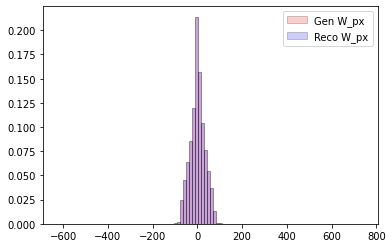

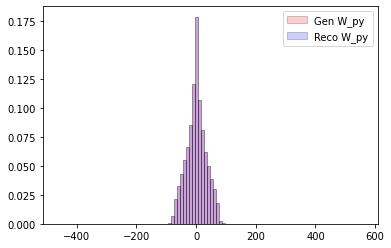

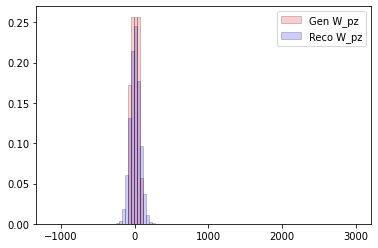

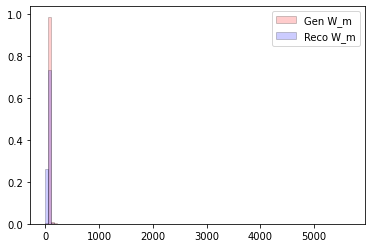

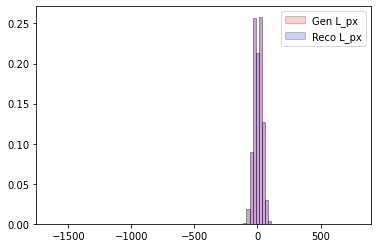

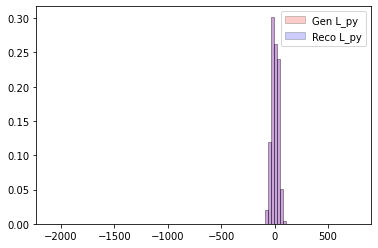

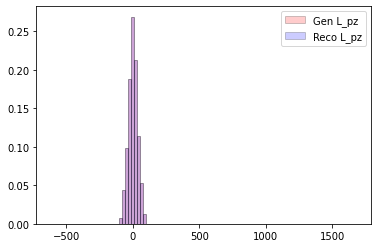

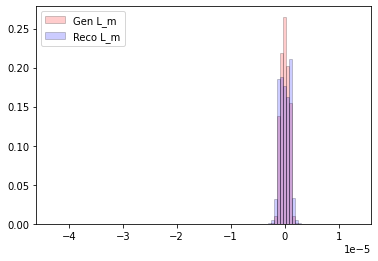

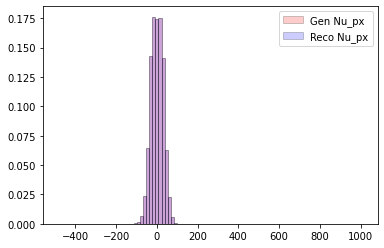

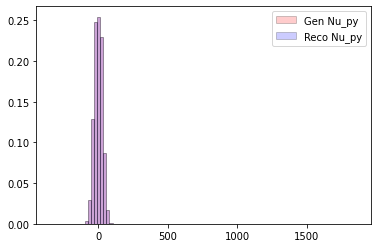

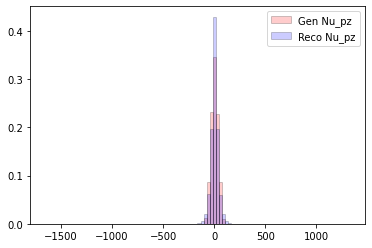

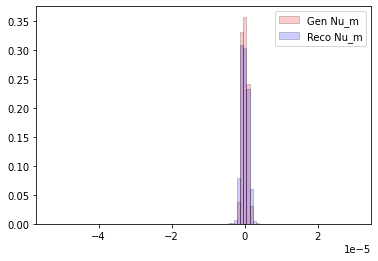

In [55]:
plot_hist(gen_df, reco_df.drop(labels=["MET_x", "MET_y"], axis=1), "Reco")

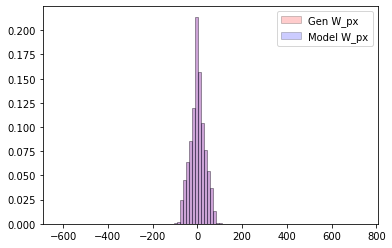

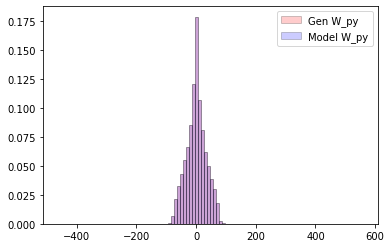

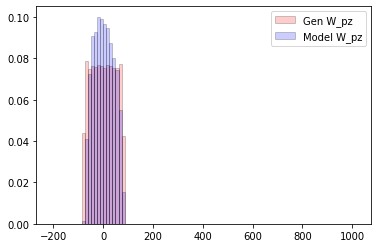

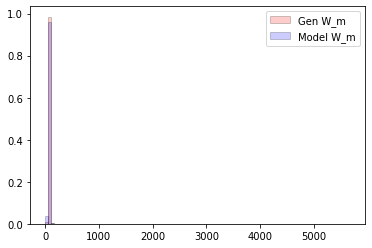

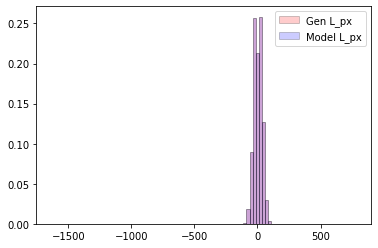

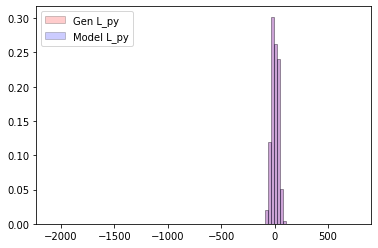

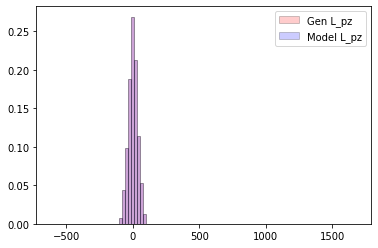

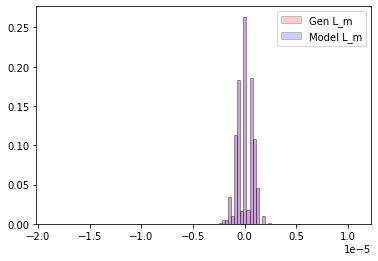

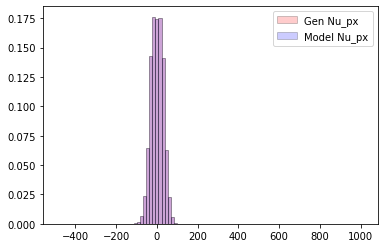

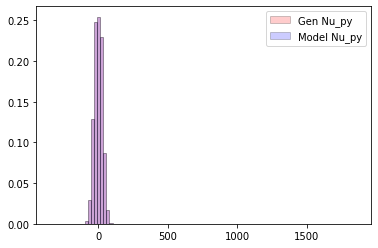

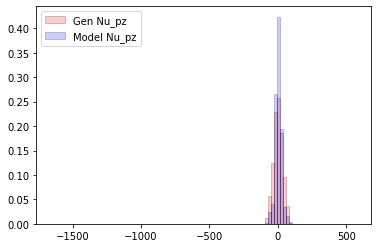

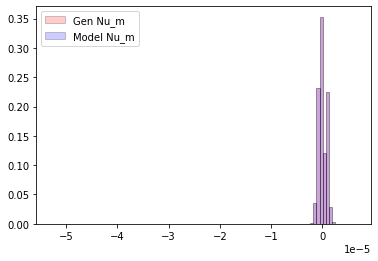

In [56]:
plot_hist(gen_df, model_df, "Model")

In [61]:
def plot_many_hists(*dfs, names=["Gen", "Reco", "Model"]):
    for col_name in dfs[0].columns:
        
        cols = [df[col_name] for df in dfs]
        
        bins = np.histogram(np.hstack(cols), bins=100)[1]
        
        kwargs = {
            "bins": bins,
            "alpha": 0.5,
            "edgecolor": "black"
        }
        colors = ["red", "blue", "green"]
        
        plt.figure()

        for (name, color, col) in zip(names, colors, cols):
            plt.hist(col, label=f"{name} {col_name}", color=color, weights=norm_weights(col), **kwargs)
        plt.legend()

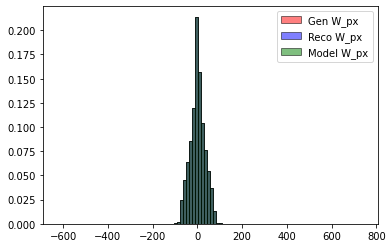

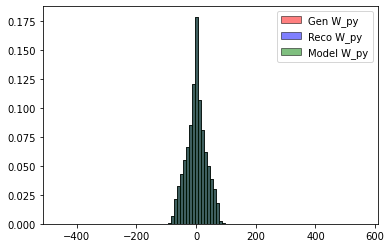

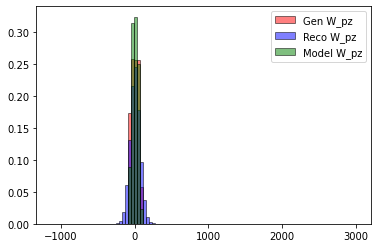

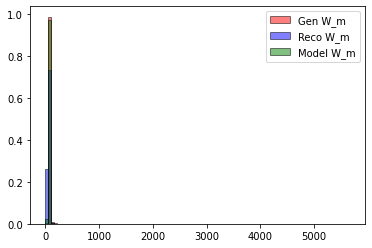

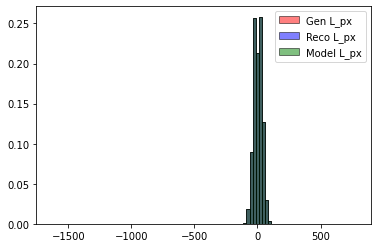

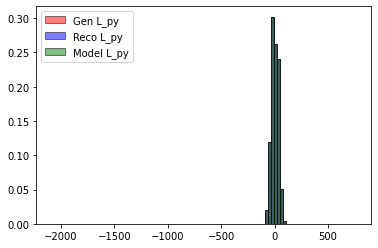

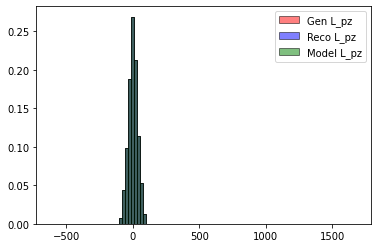

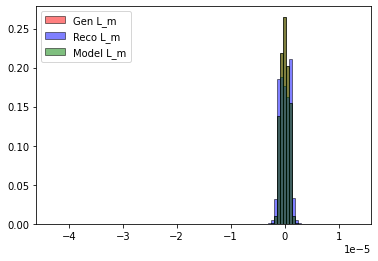

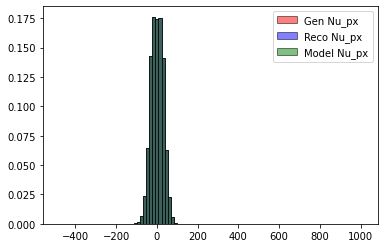

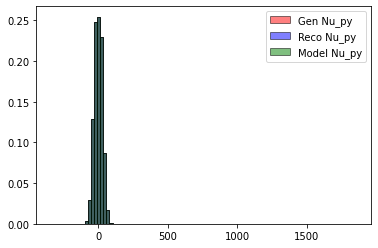

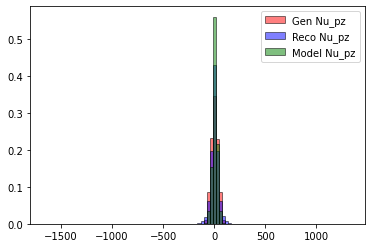

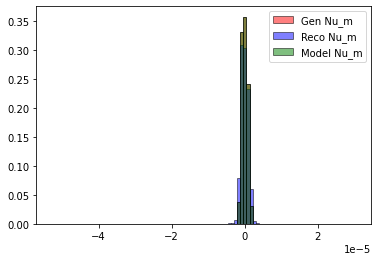

In [62]:
plot_many_hists(gen_df, reco_df, model_df)